### This notebook shows how to run experiments similar to the ones in the paper. <br>Collecting data cell should run for about 3 hours. Faster experiments can run if the dnf list is changed.

In [32]:
import sys  
sys.path.insert(0, "../src")

import gzip
import json
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
import Banzhaf_Algorithms
from DNF import DNF

# Collecting success and run time data

In [3]:
with open('academic_dnfs.json.gz', 'rt', encoding='utf-8') as f:
    dnfs = json.load(f)
    
times_adaban, times_exaban = [], []
for dnf in dnfs:
    start = time.time()
    Banzhaf_values_adaban = Banzhaf_Algorithms.ADABAN(DNF(dnf["dnf"]), epsilon=0.1, timeout=100)
    end = time.time()
    if Banzhaf_values_adaban["status"] == "Success":
        times_adaban.append(('AdaBan', True, end - start))
    else:
        times_adaban.append(('AdaBan', False, -1))
    start = time.time()
    Banzhaf_values_exaban = Banzhaf_Algorithms.calculate_banzhaf(DNF(dnf["dnf"]), timeout=100)
    end = time.time()
    if Banzhaf_values_adaban["status"] == "Success":
        times_exaban.append(('ExaBan', True, end - start))
    else:
        times_exaban.append(('ExaBan', False, -1))
    

len(times_adaban)
len(times_exaban)

7865

# Collecting provenance properties data

In [5]:
dnf_properties = []
for d in dnfs:
    dnf = DNF(d["dnf"])
    dnf_properties.append({"variable_count": dnf.variable_count, "clause_count": dnf.clause_count()})
len(dnf_properties)

7865

# Breakdown of running times

In [21]:
def get_table_row(algorithm, db, times):
    success_rate = str(round(100*len([t for t in times if t[1]])/len(times), 4)) + "%"
    successes_times = [t[2] for t in times if t[1]]
    row = {
        "Database": db,
        "Algorithm": algorithm,
        "Success rate": success_rate,
        "Mean": statistics.mean(successes_times),
        "Median": statistics.median(successes_times),
        "p75": np.percentile(successes_times, 75),
        "p90": np.percentile(successes_times, 90),
        "p95": np.percentile(successes_times, 95),
        "p99": np.percentile(successes_times, 99),
        "max": max(successes_times)
    }
    return row

In [24]:
rows = [get_table_row("Exaban", "Academic", times_exaban), get_table_row("AdaBan", "Academic", times_adaban)]
table_df = pd.DataFrame(rows)
table_df

,Database,Algorithm,Success rate,Mean,Median,p75,p90,p95,p99,max
0,Academic,Exaban,99.9746%,0.973082,0.0,0.000953,0.002535,0.005056,77.376289,106.956937
1,Academic,AdaBan,99.9746%,0.341659,0.0,0.000000,0.002109,0.005046,27.768704,47.193837


 # Running times by different parameters

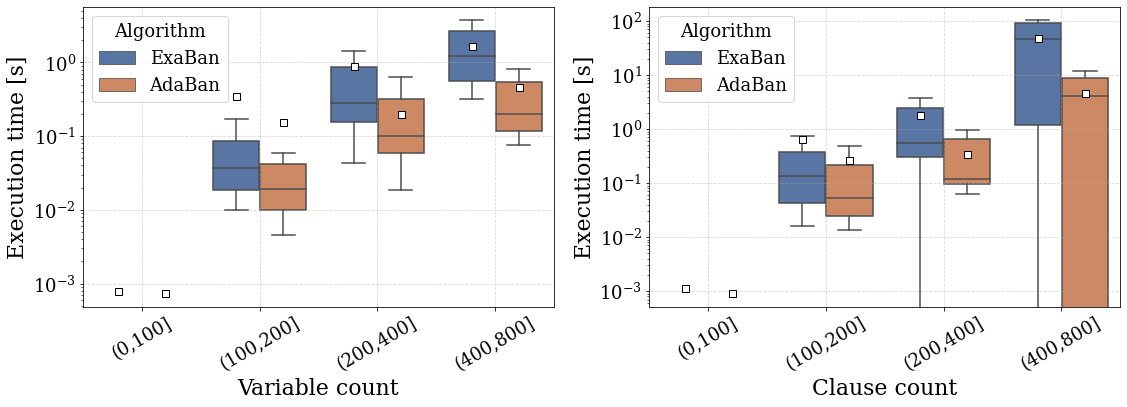

In [97]:
data = [[t[0], t[2], dnf_properties[idx]["variable_count"], dnf_properties[idx]["clause_count"]] for idx, t in enumerate(times_exaban)]
data.extend([[t[0], t[2], dnf_properties[idx]["variable_count"], dnf_properties[idx]["clause_count"]] for idx, t in enumerate(times_adaban)])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
palette = sns.color_palette("deep")


plt.style.use('seaborn-bright')
columns = ['Algorithm', "Execution time [s]", 'Variable count', 'Clause count']
df = pd.DataFrame(data=data, columns=columns)
bins = [0, 100, 200, 400, 800]
bin_labels = [f"({bins[i]},{bins[i+1]}]" for i in range(len(bins)- 1)]
df = pd.DataFrame(data=data, columns=columns)
df.loc[:, 'Variable count'] = pd.cut(df['Variable count'], bins=bins,
                        labels=bin_labels,
                        duplicates="drop")
df.loc[:, 'Clause count'] = pd.cut(df['Clause count'], bins=bins,
                        labels=bin_labels,
                        duplicates="drop")
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18

sns.boxplot(ax=axs[0], data=df, x='Variable count', y='Execution time [s]', hue='Algorithm', palette=[palette[i] for i in [0,1]], showfliers=False,
                 showmeans=True,
                 meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 7})
sns.boxplot(ax=axs[1], data=df, x='Clause count', y='Execution time [s]', hue='Algorithm', palette=[palette[i] for i in [0,1]], showfliers=False,
                 showmeans=True,
                 meanprops={"marker": "s", "markerfacecolor": "white", "markeredgecolor": "black", "markersize": 7})


for i in [0,1]:
    axs[i].tick_params(axis='x', labelsize=18, rotation=30)
    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].yaxis.get_label().set_fontsize(22)
    axs[i].xaxis.get_label().set_fontsize(22)
    axs[i].set_yscale('log')

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.show()